# Imports

In [1]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import cooper

torch.manual_seed(0)
np.random.seed(0)

### Least Squares Problem

$$
\begin{align*}
\underset{x}{min} \quad x^Tx \\
s.t. \quad Ax = b
\end{align*}
$$

With $x \in \mathbb{R}^n, \, A \in \mathbb{R}^{p \times n}, \, b \in \mathbb{R}^{p}$. In this case the p will correspond to the number of equations and n to the number of variables.

The Lagrangian is:

$$
L(x, v) = x^Tx + v^T(Ax - b)
$$

And its domain is $\mathbb{R}^n \times \mathbb{R}^p$

### Define Hyperparameters

In [2]:
n_vars = 20         # n
n_eq = 2            # p
scaling_value = 1

### Randomly build matrices

In [3]:
A = torch.rand(size=(n_eq,n_vars))*scaling_value
b = torch.rand(size=(n_eq,1))*scaling_value

A.shape, b.shape

(torch.Size([2, 20]), torch.Size([2, 1]))

### Check for feasibility

- Unique Solution:

The system has unique solution when the equations are all consistent and the number of equations are equal to the number of rows. Simply put, if the non-augmented matrix has a nonzero determinant. This problem is not interesting for us because it will only test the algorithms ability to arrive to the solution of the system.

- Infinetely many solutions

The number of equations is less than the number of variables. This is the problem that we are interested in, since we will want to find the variables that minimize the squared norm and satisfy the linear system.

- No solutions

 If the linear system is inconsistent, this is, the rank of the non-augmented matrix is not equal to the rank of the augmented matrix. Generally this happens when we have more equations than variables.

In [4]:
if n_eq == n_vars:
    det = torch.det(A)
    print(f'A is a square matrix with determinant {det}')
    assert det.item() != 0, 'A is not invertible'

# Check for consistency of the formulation
augmented_matrix = torch.cat([A, b], dim=1)
rank_A = torch.linalg.matrix_rank(A)
rank_aug = torch.linalg.matrix_rank(augmented_matrix)

print(f'Augmented matrix rank: {rank_aug}\nMatrix rank: {rank_A}')

assert rank_aug == rank_A, "A rank is different from A|b rank"

print('It has infinite solutions')

Augmented matrix rank: 2
Matrix rank: 2
It has infinite solutions


### CMP definition

In [2]:
class LeastSquares(cooper.ConstrainedMinimizationProblem):
    def __init__(self, A: torch.tensor, b: torch.tensor) -> None:
        self.A = A
        self.b = b
        super().__init__(is_constrained=True)

    def closure(self, x: torch.tensor) -> cooper.CMPState:

        loss = torch.matmul(torch.t(x), x)

        eq_defect = torch.matmul(self.A, x) - self.b

        return cooper.CMPState(
            loss=loss, eq_defect=eq_defect
        )

In [6]:
# Instantiate the problem and the lagrangian formulation associated with it.
cmp = LeastSquares(A, b)
formulation = cooper.LagrangianFormulation(cmp)

# Instantiate the variable to optimize
x = torch.nn.Parameter(torch.rand(n_vars, 1))

# Instantiate the optimizers
primal_optimizer = torch.optim.SGD([x], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial_optimizer(
    torch.optim.SGD, lr=9e-3, momentum=0.7
    )

# Instatiate the constrained optimizer
coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

### Start the optimization process

In [7]:
state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

for iter_num in range(5000):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, x)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, x)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(x.data)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

print(cmp.state)

CMPState(loss=tensor([[0.0716]], grad_fn=<MmBackward0>), ineq_defect=None, eq_defect=tensor([[5.9605e-08],
        [1.7881e-07]], grad_fn=<SubBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


### Print the results

In [1]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]).squeeze())
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]).squeeze(), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()

NameError: name 'state_history' is not defined

### Experimentation

We can encapsulate the whole process in a function that may allows us to experiment with different hyperparameters

In [3]:
def solve_cmp(
    n_eq: int,
    n_vars: int,
    scaling_value: float,
    primal_lr: float,
    dual_lr: float,
    n_iter: int,
    primal_optimizer_type: str,
    dual_optimizer_type: str
) -> None:

    """Solves the constrained minimization problem with the given parameters."""

    # Randomly generate the matrices
    A = torch.rand(size=(n_eq,n_vars))*scaling_value
    b = torch.rand(size=(n_eq,1))*scaling_value

    print(f'A matrix shape: {A.shape}\nb vector shape: {b.shape}')

    # Check for consistency of the formulation
    if n_eq == n_vars:
        det = torch.det(A)
        print(f'A is a square matrix with determinant {det}')
        assert det.item() != 0, 'A is not invertible'
        print('It has unique solution.')

    augmented_matrix = torch.cat([A, b], dim=1)
    rank_A = torch.linalg.matrix_rank(A)
    rank_aug = torch.linalg.matrix_rank(augmented_matrix)

    print(f'Augmented matrix rank: {rank_aug}\nMatrix rank: {rank_A}')
    assert rank_aug == rank_A, "A rank is different from A|b rank"
    print('It has solution.')

    # Instantiate the problem and the lagrangian formulation associated with it.
    cmp = LeastSquares(A, b)
    formulation = cooper.LagrangianFormulation(cmp)

    # Instantiate the variable to optimize
    x = torch.nn.Parameter(torch.rand(n_vars, 1))

    # Instantiate the optimizers
    if primal_optimizer_type == "SGD":
        primal_optimizer = torch.optim.SGD([x], lr=3e-2, momentum=0.7)
    else:
        primal_optimizer = cooper.optim.ExtraSGD([x], lr=3e-2, momentum=0.7)

    if dual_optimizer_type == "SGD":
        dual_optimizer = cooper.optim.partial_optimizer(
            torch.optim.SGD, lr=9e-3, momentum=0.7
        )
    else:
        dual_optimizer = cooper.optim.partial_optimizer(
            cooper.optim.ExtraSGD, lr=9e-3, momentum=0.7
        )

    # Instatiate the constrained optimizer
    coop = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

    # Run optimization
    for iter_num in range(n_iter):

        coop.zero_grad()
        lagrangian = formulation.composite_objective(cmp.closure, x)
        formulation.custom_backward(lagrangian)
        coop.step(cmp.closure, x)

        partial_dict = {"params": copy.deepcopy(x.data)}
        state_history.store_metrics(formulation, iter_num, partial_dict)

    print(cmp.state)

    # # Plot the optimization metrics
    # all_metrics = state_history.unpack_stored_metrics()

    # fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

    # ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]).squeeze())
    # ax0.set_title("Multipliers")

    # ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]).squeeze(), alpha=0.6)
    # ax1.axhline(0.0, c="gray", alpha=0.2)
    # ax1.set_title("Defects")

    # ax2.plot(all_metrics["iters"], all_metrics["loss"])
    # ax2.set_title("Objective")

    # [_.semilogx() for _ in (ax0, ax1, ax2)]
    plt.show()

### Run and play

In [5]:
n_vars = 7
n_eq = 5
scaling_value = 1
primal_lr = 3e-2
dual_lr = 9e-3
n_iter = 10000
primal_optimizer_type = "SGD"
dual_optimizer_type = "SGD"

solve_cmp(n_eq, n_vars, scaling_value, primal_lr, dual_lr, n_iter, primal_optimizer_type, dual_optimizer_type)

A matrix shape: torch.Size([5, 7])
b vector shape: torch.Size([5, 1])
Augmented matrix rank: 5
Matrix rank: 5
It has solution.
CMPState(loss=tensor([[0.7455]], grad_fn=<MmBackward0>), ineq_defect=None, eq_defect=tensor([[ 1.9073e-06],
        [ 3.9190e-06],
        [-3.5763e-07],
        [ 3.5763e-07],
        [ 1.8775e-06]], grad_fn=<SubBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


### Solve an Unconstrained Problem using Cooper

The dual fucntion is given by $g(v) = \underset{x}{inf} L(x, v)$, and since the Lagrangian is a convex quadratic function we can find the minimizing x by derivating:

$$
\begin{align}
\nabla_x L(x, v) = 2x + A^Tv = 0 \\
x = -(1/2)A^Tv
\end{align}
$$

Therefore the dual function is:

$$
g(v) = L(-(1/2)A^Tv, v)= -(1/4)v^TAA^Tv - b^Tv
$$

Which is a concave function.

Let's try to solve this unconstrained version of the dual function.

In [31]:
n_vars = 20
n_eq = 2

A = torch.rand(size=(n_eq,n_vars))
b = torch.rand(size=(n_eq,1))

augmented_matrix = torch.cat([A, b], dim=1)

A.shape, b.shape, torch.linalg.matrix_rank(augmented_matrix) == n_eq

(torch.Size([2, 20]), torch.Size([2, 1]), tensor(True))

In [44]:
class LagrangianAnalytical(cooper.ConstrainedMinimizationProblem):
    def __init__(self, A, b):
        self.A = A
        self.b = b
        super().__init__(is_constrained=False)

    def closure(self, v):

        vAAv = torch.matmul(torch.matmul(torch.t(v), self.A), torch.matmul(torch.t(self.A), v))
        bv = torch.matmul(torch.t(self.b), v)

        loss = (1/4)*vAAv + bv

        return cooper.CMPState(loss=loss)

In [59]:
# Instantiate the problem and the lagrangian formulation associated with it.
cmp = LagrangianAnalytical(A, b)
formulation = cooper.LagrangianFormulation(cmp)

# Instantiate the variable to optimize
v = torch.nn.Parameter(torch.rand(n_eq, 1))

# Instantiate the optimizers
primal_optimizer = torch.optim.SGD([v], lr=3e-2, momentum=0.7)

# Instatiate the constrained optimizer
coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
)

In [60]:
state_history = cooper.StateLogger(save_metrics=["loss"])

for iter_num in range(5000):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, v)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, v)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(v.data)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

print(cmp.state)

CMPState(loss=tensor([[-0.0285]], grad_fn=<AddBackward0>), ineq_defect=None, eq_defect=None, proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


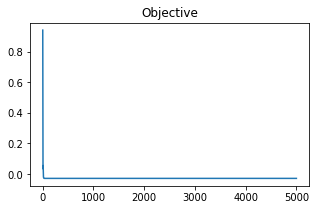

In [61]:
all_metrics = state_history.unpack_stored_metrics()

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(5, 3))

ax.plot(all_metrics["iters"], all_metrics["loss"])
ax.set_title("Objective")
plt.show()